# Assignment

Use the "from the expert" (FTE) jupyter notebook as a starter for this assignment, and ask your instructor questions if you need help.

Use the `churn_data.csv` file to carry out a similar data cleaning and preparation as we did in the FTE. Specifically, at least complete these minimum requirements:

- Check for outliers in numeric data, and deal with them if needed
- Check for missing values, and decide how to deal with them if needed
- Convert categorical columns to numeric values
- Create at least one new feature by combining multiple columns. For example, you could calculate the ratio of total charges to tenure. Create at least one plot for your new feature.
- Save the data to a csv (or another filetype of your choice) for use next week.
- Write a short analysis at the end of the notebook describing your findings and what you did.

You can do more data cleaning, preparation, and EDA beyond these basic requirements if you want to learn more and develop your data science skills. For example, you could use a box-cox transformation on the numeric data or try other outlier methods.

### DS process status

Here is our data science process, and where we are (#3):

**1. Business understanding**

Can we use machine learning to predict if a customer will churn before they leave?

**2. Data understanding**

Done in week 1 (mostly), this is iterative so you might do more of this as we go on.

**3. Data preparation**

We are here this week.


**4. Modeling**

Next week


**5. Evaluation**

Next week


**6. Deployment**

Next week

## Data Preparation - Tyler Osterberg - Week 2

In [1]:
!conda install -c conda-forge pyod -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Tyler\anaconda3

  added / updated specs:
    - pyod


The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.11.0-py38haa95532_0 --> conda-forge::conda-4.11.0-py38haa244fe_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [2]:
# Import and setup

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('churn_data.csv', index_col='customerID')

In [4]:
data

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No
4801-JZAZL,11,No,Month-to-month,Electronic check,29.60,346.45,No


### Data filtering

In [5]:
data_churned = data[data['Churn'] == 'Yes']
data_churned.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
9305-CDSKC,8,Yes,Month-to-month,Electronic check,99.65,820.50,Yes
7892-POOKP,28,Yes,Month-to-month,Electronic check,104.80,3046.05,Yes
0280-XJGEX,49,Yes,Month-to-month,Bank transfer (automatic),103.70,5036.30,Yes


In [6]:
data_high_monthly_payment = data[data['MonthlyCharges'] > data['MonthlyCharges'].median()]
data_high_monthly_payment.head()


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
9305-CDSKC,8,Yes,Month-to-month,Electronic check,99.65,820.50,Yes
1452-KIOVK,22,Yes,Month-to-month,Credit card (automatic),89.10,1949.40,No
7892-POOKP,28,Yes,Month-to-month,Electronic check,104.80,3046.05,Yes
8091-TTVAX,58,Yes,One year,Credit card (automatic),100.35,5681.10,No


In [7]:
# Creating some functions for splitting the data more generically

def split_df_by_median(dat, col):
  above = dat[dat[col] > dat[col].median()]
  below = dat[dat[col] <= dat[col].median()]
  return [above, below]

def split_df_by_category(dat, col):
  split_array = []
  values = dat[col].unique()
  for value in values:
    split_array.append(dat[dat[col] == value])
  return split_array

[test_median_high, test_median_low] = split_df_by_median(data, 'MonthlyCharges')
[test_contract_one, test_contract_two, test_contract_three] = split_df_by_category(data, 'Contract')
[pm_one, pm_two, pm_three, pm_four] = split_df_by_category(data, 'PaymentMethod')
[phone_no, phone_yes] = split_df_by_category(data, 'PhoneService')
[churn_no, churn_yes] = split_df_by_category(data, 'Churn')
churn_no


,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
1452-KIOVK,22,Yes,Month-to-month,Credit card (automatic),89.10,1949.40,No
6713-OKOMC,10,No,Month-to-month,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...
2569-WGERO,72,Yes,Two year,Bank transfer (automatic),21.15,1419.40,No
6840-RESVB,24,Yes,One year,Mailed check,84.80,1990.50,No
2234-XADUH,72,Yes,One year,Credit card (automatic),103.20,7362.90,No


### Test Distribution

<AxesSubplot:>

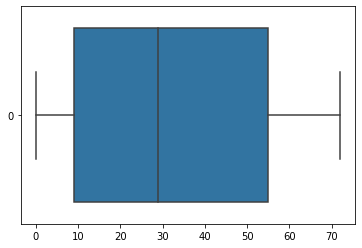

In [8]:
sns.boxplot(data=data.tenure, orient='h')


<AxesSubplot:xlabel='tenure', ylabel='Count'>

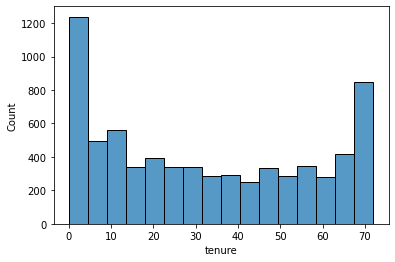

In [9]:
sns.histplot(data=data.tenure)

<AxesSubplot:>

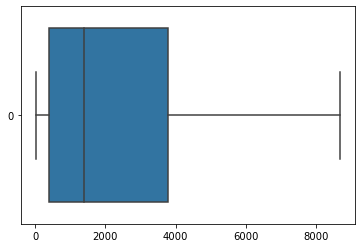

In [10]:
sns.boxplot(data=data.TotalCharges, orient='h')

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

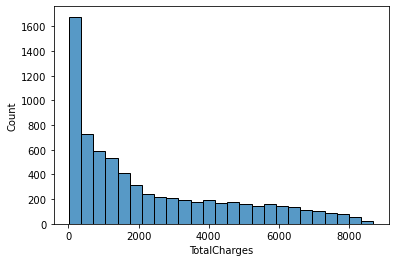

In [11]:
sns.histplot(data=data.TotalCharges)

<AxesSubplot:>

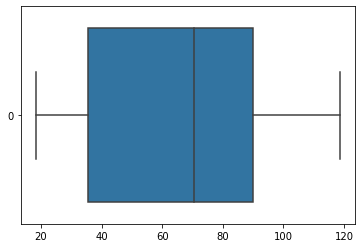

In [12]:
sns.boxplot(data=data.MonthlyCharges, orient='h')

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

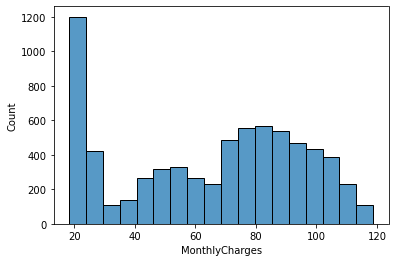

In [13]:
sns.histplot(data=data.MonthlyCharges)

### Test Outliers

In [14]:

def get_boundaries(dat, col):
    q1 = dat[col].quantile(0.25)
    q3 = dat[col].quantile(0.75)
    iqr = q3 - q1
    upper_boundary = q3 + 1.5 * iqr
    lower_boundary = q1 - 1.5 * iqr
    return [upper_boundary, lower_boundary]

def iqr_test(dat, col):
  [upper_boundary, lower_boundary] = get_boundaries(dat, col)
  return dat[(dat[col] < lower_boundary) | (dat[col] > upper_boundary)][col]

tenure_outliers = iqr_test(data, 'tenure')
tenure_outliers


Series([], Name: tenure, dtype: int64)

In [15]:
monthly_outliers = iqr_test(data, 'MonthlyCharges')
monthly_outliers

Series([], Name: MonthlyCharges, dtype: float64)

In [16]:
total_outliers = iqr_test(data, 'TotalCharges')
total_outliers

Series([], Name: TotalCharges, dtype: float64)

In [17]:
def std_outliers_test(dat, col):
  values = []
  std = dat[col].std()
  total = dat[col].count()
  for i in range(3):
    top = dat[dat[col] > (dat[col].mean() + std*(i+1))][col].count()
    bottom = dat[dat[col] < (dat[col].mean() - std*(i+1))][col].count()
    values.append([((total - (top + bottom)) / total), i+1])
  return values

def concat_outlier_test(dat, cols):
  response = []
  for col in cols:
    response.append(std_outliers_test(dat, col))
  return response

columns = ['tenure','MonthlyCharges','TotalCharges']
concat_outlier_test(data, columns)


[[[0.533295470680108, 1], [1.0, 2], [1.0, 3]],
 [[0.5683657532301576, 1], [1.0, 2], [1.0, 3]],
 [[0.8065984072810012, 1], [0.9439704209328783, 2], [1.0, 3]]]

It appears that none of our numeric columns have any outliers, first when looking at the boxplot, and second when testing IQR. It might not even be accurate to use the IQR test since the data does not appear to be normally distributed.

<AxesSubplot:>

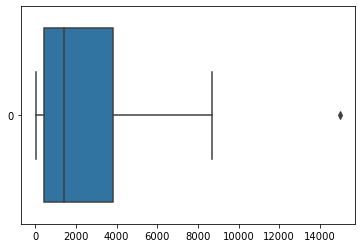

In [18]:
# make a copy so as to to alter the original data practicing by inserting and trimming an outlier
column = columns[2]
data_copy = data.copy()
mask = data_copy['TotalCharges'] == data_copy['TotalCharges'].max()
data_copy.loc[mask, 'TotalCharges'] = 15000
sns.boxplot(data=data_copy.TotalCharges, orient='h')



<AxesSubplot:>

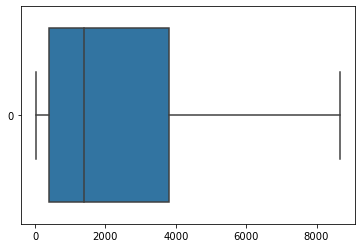

In [19]:
# Removal of outliers by assigning np.nan
df = data_copy.copy()
[upper, lower] = get_boundaries(data_copy, column)
df.at[data_copy[column] < lower, column] = np.nan
df.at[data_copy[column] > upper, column] = np.nan
sns.boxplot(data=df.TotalCharges, orient='h')

<AxesSubplot:>

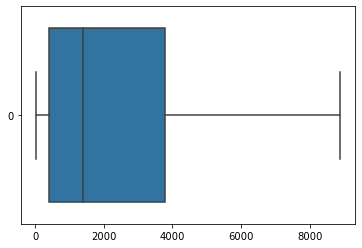

In [20]:
# Inplace removal of outliers using clip
data_copy[column].clip(lower=lower, upper=upper, inplace=True)
sns.boxplot(data=data_copy.TotalCharges, orient='h')


### Test Missing Data

In [21]:
data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [22]:
data.isna().sum()

tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

In [23]:
# Option 1 - Removing incomplete observations
drop_na_data = data.copy()
drop_na_data.dropna(inplace=True)
drop_na_data.isna().sum()

tenure            0
PhoneService      0
Contract          0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

In [24]:
drop_na_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [25]:
# Observing the changes that this does to the data
data.describe() - drop_na_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,11.000000,11.000000,0.0
mean,-0.050637,-0.036516,0.0
std,0.014221,0.004073,0.0
min,-1.000000,0.000000,0.0
25%,0.000000,-0.087500,0.0
50%,0.000000,0.000000,0.0
75%,0.000000,-0.012500,0.0
max,0.000000,0.000000,0.0


In [26]:
# Option 2 - Replace with the median value (better than mean for skewed distributions)
filled_median_na_data = data.copy()
filled_median_na_data.fillna(filled_median_na_data['TotalCharges'].median(), inplace=True)
filled_median_na_data.isna().sum()

tenure            0
PhoneService      0
Contract          0
PaymentMethod     0
MonthlyCharges    0
TotalCharges      0
Churn             0
dtype: int64

In [27]:
filled_median_na_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928
std,24.559481,30.090047,2265.270398
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [28]:
# Observing the changes that this does to the data
data.describe() - filled_median_na_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,0.0,0.0,-11.000000
mean,0.0,0.0,1.383513
std,0.0,0.0,1.500963
min,0.0,0.0,0.000000
25%,0.0,0.0,-0.775000
50%,0.0,0.0,0.000000
75%,0.0,0.0,8.137500
max,0.0,0.0,0.000000


### Converting Categorical Features to Numerical

In [29]:
data = filled_median_na_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   PhoneService    7043 non-null   object 
 2   Contract        7043 non-null   object 
 3   PaymentMethod   7043 non-null   object 
 4   MonthlyCharges  7043 non-null   float64
 5   TotalCharges    7043 non-null   float64
 6   Churn           7043 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 698.2+ KB


In [30]:
data['PhoneService'].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [31]:
# Converting PhoneService to numeric
data['PhoneService'] = data['PhoneService'].replace({'No': 0, 'Yes': 1})
data['PhoneService'].value_counts()

1    6361
0     682
Name: PhoneService, dtype: int64

In [32]:
data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [33]:
data['Contract'] = data['Contract'].replace({'Month-to-month': 0, 'One year': 1 ,'Two year': 2})
data['Contract'].value_counts()

0    3875
2    1695
1    1473
Name: Contract, dtype: int64

In [34]:
data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [35]:
data['PaymentMethod'] = data['PaymentMethod'].replace({'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3})
data['PaymentMethod'].value_counts()

0    2365
1    1612
2    1544
3    1522
Name: PaymentMethod, dtype: int64

In [36]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [37]:
data['Churn'] = data['Churn'].replace({'No': 0, 'Yes': 1})
data['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

### Feature Engineering

<AxesSubplot:ylabel='Frequency'>

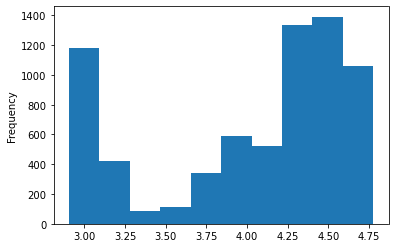

In [38]:
log_data_copy = data.copy()
log_data_copy['MonthlyCharges'] = np.log(log_data_copy['MonthlyCharges'])
log_data_copy['MonthlyCharges'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

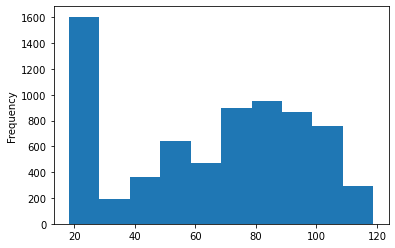

In [39]:
# Compared to the original data feature
data['MonthlyCharges'].plot.hist()

#### Extracting Feature from Categorical Column

In [40]:
# One implied feature from the data is automatic payment enabled, so lets make that a column on the data
data['AutoPay'] = data['PaymentMethod'].copy()
data['AutoPay'] = data['AutoPay'].replace([0, 1], 0)
data['AutoPay'] = data['AutoPay'].replace([2, 3], 1)
data['AutoPay'].value_counts()


0    3977
1    3066
Name: AutoPay, dtype: int64

<AxesSubplot:>

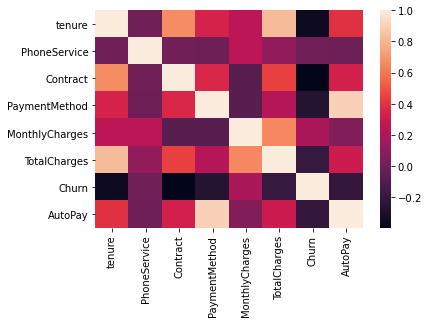

In [41]:
sns.heatmap(data.corr())

In [42]:
data['AverageMonthly'] = data['TotalCharges'] / data['tenure']
data['CurrentMonthly/Average'] = (data['MonthlyCharges'] - data['AverageMonthly'])*100


<AxesSubplot:>

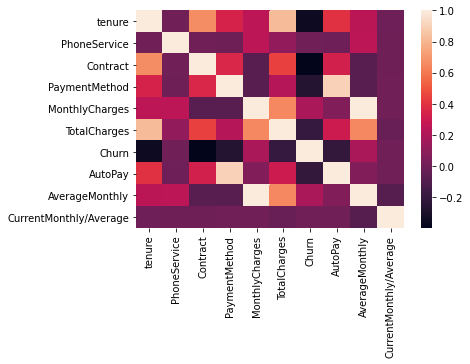

In [43]:
sns.heatmap(data.corr())

In [44]:
# That feature seems completely unusable, so lets drop it
data.drop('CurrentMonthly/Average', axis=1)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AutoPay,AverageMonthly
customerID,,,,,,,,,
7590-VHVEG,1,0,0,0,29.85,29.85,0,0,29.850000
5575-GNVDE,34,1,1,1,56.95,1889.50,0,0,55.573529
3668-QPYBK,2,1,0,1,53.85,108.15,1,0,54.075000
7795-CFOCW,45,0,1,2,42.30,1840.75,0,1,40.905556
9237-HQITU,2,1,0,0,70.70,151.65,1,0,75.825000
...,...,...,...,...,...,...,...,...,...
6840-RESVB,24,1,1,1,84.80,1990.50,0,0,82.937500
2234-XADUH,72,1,1,3,103.20,7362.90,0,1,102.262500
4801-JZAZL,11,0,0,0,29.60,346.45,0,0,31.495455


In [45]:
 # Export cleaned data to csv
data.to_csv('prepped_churn_data.csv')

### Summary

Doing further analysis on the churn data this week was a lot of fun.  We started off with looking at the shapes of the distributions that our numeric features were showing when plotted.  This showed that the majority of our numeric data was not normally distributed and also seemed to lack outliers.  We tested using the IQR and by seeing the data points under the first three standard deviations.  Additionally we practiced removing na's through two methods.  The first being that we drop the affected observations which would have resulted in the loss of 11 observations specific statistical description of the change available above, as the second was filling the na's with the median value of the feature.  Both had and effect and ultimately I decided to proceed with the data that had been filled in with the median for my first prepared dataset.

Once the na's and outliers had been dealt with the next course of action was to see if there were features that could be engineered to provide more insight into the data.  I went back to my week one analysis and decided to create a new feature that was whether or not the customer was on auto-pay.  This was engineered from the PaymentMethods feature and showed a good negative correlation to Churn, so it will be kept.  The second feature we explored was a possible disconnect between the current monthly charges when compared to the average monthly charges over the customers tenure.  Unfortunately that feature appeared to have no correlation with any other features and was subsequently dropped from the prepared data for next week.